# Benchmark Evaluation for Predictive Monitoring of Remaining Cycle Time of Business Processes

In [1]:
# connect to local working directory on Google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# install required libraries
!pip install lime

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=354313f3af22f89e6f0bd65b18fca06a888953eefc6b053a49a2267052cf6b18
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
# Define main workspace directory path
MY_WORKSPACE_DIR = "/content/drive/My Drive/Colab Notebooks/CAiSE/"
#MY_WORKSPACE_DIR = "/Users/catarina/Google Drive/Colab Notebooks/CAiSE/"

# add my working directory to the colab path
import sys
from sys import argv

sys.path.append(MY_WORKSPACE_DIR)

In [4]:
# Install tensorflow
try:
    # tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [5]:
import warnings
warnings.filterwarnings('ignore')

# keras / deep learning libraries
from tensorflow import keras

# models
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json

# layers
from tensorflow.keras.layers import Dense, LSTM,InputLayer, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.layers import Input, Lambda, Flatten, Dropout, AveragePooling1D 
from tensorflow.keras.layers import AveragePooling2D, AveragePooling3D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, BatchNormalization

# optimizers
from tensorflow.compat.v1.train import Optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# other keras functions
from tensorflow.keras.utils import Sequence, plot_model, to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.initializers import glorot_uniform

# sklearn library
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV 
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline, FeatureUnion

# LIME - Explainability
import lime
import lime.lime_tabular
from lime import submodular_pick; # not using this but useful later.

# serialise models
from numpy import loadtxt
import pickle

# visualization
#from misc.misc import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig

import seaborn as sns
sns.set()

from time import time

import itertools
import pickle
import os
import pandas as pd
import numpy as np
import csv
from numpy import array


Using TensorFlow backend.


## Predictive Process Monitoring: Remaining Time Prediction

Given an event log of complete cases of a business process, and a prefix case of the process as obtained from an event stream, we want to predict a performance measure of such prefix case in the future. For example, we may wsnt to predict the time of this case until completion (or remaining time) or its outcomeat completion. A **prediction point** is a point in the future where the performance measure has a predicted value. A prediction is thus based o nthe predictor's knowledge of the history of the process until the prediction point as well as knowledge of the future until the predicted point. The former is warrented by the predictor's **memory** while the latter is based on  the predictor's **forecast**, i.e., predicting the future based based on the trend nd seasonal patern analysis. Finally, the prediction is performed based on  a**prediction** algorithm.
Since in real-life business processes the amount of uncertainty increases over time, the prediction task becomes more difficult and genersally less acurate. As such, predictions are made up to a specific point of time in the future, i.e., the time zone **h**. The choice of **h** depends on how fast the process evolves and on the prediction goal.

### Research Questions

Research questions analysed in paper
:
  - What methods exist for predictive monitoring of remaining time of business processes?
  - How to classify methods for predictive monitoring of remaining time?
  - What tyoe of data has been used to evaluate these methods, and from which application domains?
  - What is the relative performance of these methods?

### Methodology

<img href="https://www.dropbox.com/s/4uj3yll961chfau/predictive_process_monitoring_workflow.png" />


#### Prefix Bucketing

Two possible approaches used in machine-learning-based predictive process monitoring:

  1. train a single predictor on the whole event log;
  2. employ a multiple predictor apporach by dividing the prefix traces in the historical log into several **buckets** and fitting a separate predictor for each bucket. 

The four most used bucketing methods in the literature are:
  1. Zero Bucketing
  2. Prefix length bucketing
  3. Cluster bucketing
  4. State Bucketing

  



In [0]:
def get_encoder(method, case_id_col=None, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=None, dynamic_num_cols=None, fillna=True, max_events=None):

    if method == "static":
        return StaticTransformer(case_id_col=case_id_col, cat_cols=static_cat_cols, num_cols=static_num_cols, fillna=fillna)

    elif method == "last":
        return LastStateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, fillna=fillna)

    elif method == "agg":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=False, fillna=fillna)

    elif method == "bool":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=True, fillna=fillna)
    
    elif method == "index":
        return IndexBasedTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, max_events=max_events, fillna=fillna)

    else:
        print("Invalid encoder type")
        return None

     


In [0]:
def get_bucketer(method, encoding_method=None, case_id_col=None, cat_cols=None, num_cols=None, n_clusters=None, random_state=None, n_neighbors=None):

    if method == "cluster":
        bucket_encoder = get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        clustering = KMeans(n_clusters, random_state=random_state)
        return ClusterBasedBucketer(encoder=bucket_encoder, clustering=clustering)
        
    elif method == "state":
        bucket_encoder = get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        return StateBasedBucketer(encoder=bucket_encoder)
            
    elif method == "single":
        return NoBucketer(case_id_col=case_id_col)

    elif method == "prefix":
        return PrefixLengthBucketer(case_id_col=case_id_col)
    
    elif method == "knn":
        bucket_encoder = get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        return KNNBucketer(encoder=bucket_encoder, n_neighbors=n_neighbors)

    else:
        print("Invalid bucketer type")
        return None

##### Zero bucketing 

All prefix traces are considered to be ub the same bucket. As such, a single predictor is fit for all prefies in the prefix log.

In [0]:
# All prefix traces are considered to be in the same bucket. As such, a single 
# predictor is fit for all prefies in the prefix log.
class NoBucketer(object):
    
    def __init__(self, case_id_col):
        self.n_states = 1
        self.case_id_col = case_id_col
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X, y=None):
        return np.ones(len(X[self.case_id_col].unique()), dtype=np.int)
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)

##### Prefix length bucketing

Each bucket contains the prefixes of a specific length. For instance, the *nth* bucket contains prefixes where at least *n* events have been performed. **One classifier is built for each possible prefix length**.


In [0]:
# Prefix length bucketing. Each bucket contains the prefixes of a specific 
# length. For instance, the nth bucket contains prefixes where at least n events 
# have been performed. One classifier is built for each possible prefix length.
class PrefixLengthBucketer(object):
    
    def __init__(self, case_id_col):
        self.n_states = 0
        self.case_id_col = case_id_col
        
    def fit(self, X, y=None):
        sizes = X.groupby(self.case_id_col).size()
        self.n_states = sizes.unique()
        return self
    
    def predict(self, X, y=None):    
        return X.groupby(self.case_id_col).size().as_matrix()
    
    def fit_predict(self, X, y=None):    
        self.fit(X)
        return self.predict(X)


 ##### Cluster bucketing
 
 Each bucket represents a cluster that results from applying a clustering algorithmon the encoded prefixes. One classifier is trained for each resulting cluster, considering only the historical prefixes that fall into that particular cluster. At runtime, the cluster of the running case is determined based on its similarity to each of the existing clusters and the corresponding classifier is applied.


In [0]:
# Each bucket represents a cluster that results from applying a clustering 
# algorithmon the encoded prefixes. One classifier is trained for each 
# resulting cluster, considering only the historical prefixes that fall into that 
# particular cluster. At runtime, the cluster of the running case is determined 
# based on its similarity to each of the existing clusters and the corresponding 
# classifier is applied.
class ClusterBasedBucketer(object):
    
    def __init__(self, encoder, clustering):
        self.encoder = encoder
        self.clustering = clustering
        
    def fit(self, X, y=None):
        dt_encoded = self.encoder.fit_transform(X)
        self.clustering.fit(dt_encoded)
        return self
    
    def predict(self, X, y=None):
        dt_encoded = self.encoder.transform(X)
        return self.clustering.predict(dt_encoded)
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)

##### State Bucketing

It is used in process-aware apporaches where some kind of process representation is derived and a predictor is trained for each state, or dedcision point.

In [0]:
# It is used in process-aware apporaches where some kind of process representation 
# is derived and a predictor is trained for each state, or dedcision point.
class StateBasedBucketer(object):
    
    def __init__(self, encoder):
        self.encoder = encoder
        self.dt_states = None
        self.n_states = 0
        
    def fit(self, X, y=None):
        dt_encoded = self.encoder.fit_transform(X)
        self.dt_states = dt_encoded.drop_duplicates()
        self.dt_states = self.dt_states.assign(state = range(len(self.dt_states)))
        self.n_states = len(self.dt_states)
        return self
    
    def predict(self, X, y=None):
        
        dt_encoded = self.encoder.transform(X)
        dt_transformed = pd.merge(dt_encoded, self.dt_states, how='left')
        dt_transformed.fillna(-1, inplace=True)
        return dt_transformed["state"].astype(int).as_matrix()
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)

#### Prefix Encoding

In [0]:
def get_encoder(method, case_id_col=None, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=None, dynamic_num_cols=None, fillna=True, max_events=None):

    if method == "static":
        return StaticTransformer(case_id_col=case_id_col, cat_cols=static_cat_cols, num_cols=static_num_cols, fillna=fillna)

    elif method == "last":
        return LastStateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, fillna=fillna)

    elif method == "agg":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=False, fillna=fillna)

    elif method == "bool":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=True, fillna=fillna)
    
    elif method == "index":
        return IndexBasedTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, max_events=max_events, fillna=fillna)

    else:
        print("Invalid encoder type")
        return None

##### Static Encoder

In [0]:
class StaticTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        dt_first = X.groupby(self.case_id_col).first()
        
        # transform numeric cols
        dt_transformed = dt_first[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_first[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)

        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed

##### Aggregate Transformer

In [0]:
class AggregateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, boolean=False, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        self.boolean = boolean
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        # transform numeric cols
        if len(self.num_cols) > 0:
            dt_numeric = X.groupby(self.case_id_col)[self.num_cols].agg(["mean", "max", "min", "sum", "std"])
            dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]
            
        # transform cat cols
        print(X)
        print("#########################")
        dt_transformed = pd.get_dummies(X[self.cat_cols])
        print(dt_transformed)
        print("#########################")
        dt_transformed[self.case_id_col] = X[self.case_id_col]
        print(dt_transformed)
        print("##########################")
        del X
        if self.boolean:
            dt_transformed = dt_transformed.groupby(self.case_id_col).max()
        else:
            dt_transformed = dt_transformed.groupby(self.case_id_col).sum()
        
        print(dt_transformed)
        print("##########################")
        # concatenate
        if len(self.num_cols) > 0:
            dt_transformed = pd.concat([dt_transformed, dt_numeric], axis=1)
            del dt_numeric
        
        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        
        self.transform_time = time() - start
        return dt_transformed

##### Index Based Transformer

In [0]:
class IndexBasedExtractor(TransformerMixin):
    
    def __init__(self, cat_cols, num_cols, max_events, fillna=True):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.max_events = max_events
        self.fillna = fillna
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        # add missing columns if necessary
        if self.columns is None:
            relevant_num_cols = ["%s_%s"%(col, i) for col in self.num_cols for i in range(self.max_events)]
            relevant_cat_col_prefixes = tuple(["%s_%s_"%(col, i) for col in self.cat_cols for i in range(self.max_events)])
            relevant_cols = [col for col in X.columns if col.startswith(relevant_cat_col_prefixes)] + relevant_num_cols
            self.columns = relevant_cols
        else:
            missing_cols = [col for col in self.columns if col not in X.columns]
            for col in missing_cols:
                X[col] = 0
        
        self.transform_time = time() - start
        return X[self.columns]

class IndexBasedTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, max_events=None, fillna=True, create_dummies=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.max_events = max_events
        self.fillna = fillna
        self.create_dummies = create_dummies
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        grouped = X.groupby(self.case_id_col, as_index=False)
        
        if self.max_events is None:
            self.max_events = grouped.size().max()
        
        
        dt_transformed = pd.DataFrame(grouped.apply(lambda x: x.name), columns=[self.case_id_col])
        for i in range(self.max_events):
            dt_index = grouped.nth(i)[[self.case_id_col] + self.cat_cols + self.num_cols]
            dt_index.columns = [self.case_id_col] + ["%s_%s"%(col, i) for col in self.cat_cols] + ["%s_%s"%(col, i) for col in self.num_cols]
            dt_transformed = pd.merge(dt_transformed, dt_index, on=self.case_id_col, how="left")
        dt_transformed.index = dt_transformed[self.case_id_col]
        
        # one-hot-encode cat cols
        if self.create_dummies:
            all_cat_cols = ["%s_%s"%(col, i) for col in self.cat_cols for i in range(self.max_events)]
            dt_transformed = pd.get_dummies(dt_transformed, columns=all_cat_cols).drop(self.case_id_col, axis=1)
        
        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)

        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]

        self.transform_time = time() - start
        return dt_transformed

##### Last State Transformer

In [0]:
class LastStateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
        
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        start = time()
        
        dt_last = X.groupby(self.case_id_col).last()
        
        # transform numeric cols
        dt_transformed = dt_last[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_last[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)
        
        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed

##### Previous State Transformer

In [0]:
class PreviousStateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
        
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        start = time()
        
        dt_last = X.groupby(self.case_id_col).nth(-2)
        
        # transform numeric cols
        dt_transformed = dt_last[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_last[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)

        # add 0 rows where previous value did not exist
        dt_transformed = dt_transformed.reindex(X.groupby(self.case_id_col).first().index, fill_value=0)
            
        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed
    

#### Preprocessing

Adding columns:
  - elapsed time
  - remaining time

In [18]:
input_data_folder = MY_WORKSPACE_DIR + "experiments/main_logs/"
output_data_folder = MY_WORKSPACE_DIR + "experiments/logdata/"

filenames_bpic2011 = "bpic2011.csv"

filenames_bpic2012a = "bpic2012a.csv"
filenames_bpic2012o = "bpic2012o.csv"
filenames_bpic2012w = "bpic2012w.csv"

filenames_bpic2015 = "bpic2015_5.csv"

filenames = [ filenames_bpic2011, filenames_bpic2012a, filenames_bpic2012o, filenames_bpic2012w, filenames_bpic2015 ]
timestamp_col = "Complete Timestamp"

columns_to_remove = ["label"]
case_id_col = "Case ID"

def add_remtime_column(group):
    group = group.sort_values(timestamp_col, ascending=False)
    start_date = group[timestamp_col].iloc[-1]
    end_date = group[timestamp_col].iloc[0]

    elapsed = group[timestamp_col] - start_date
    elapsed = elapsed.fillna(0)
    group["elapsed"] = elapsed.apply(lambda x: float(x / np.timedelta64(1, 's')))  # s is for seconds

    remtime = end_date - group[timestamp_col]
    remtime = remtime.fillna(0)
    group["remtime"] = remtime.apply(lambda x: float(x / np.timedelta64(1, 's'))) # s is for seconds

    return group

for filename in filenames:
    print(filename)
    #data = pd.read_csv(os.path.join(input_data_folder, filename), sep=",")
    #data = data.drop([columns_to_remove], axis=1)
    #data[timestamp_col] = pd.to_datetime(data[timestamp_col])
    #data = data.groupby(case_id_col).apply(add_remtime_column)
    #data.to_csv(os.path.join(output_data_folder, filename), sep=";", index=False)



bpic2011.csv
bpic2012a.csv
bpic2012o.csv
bpic2012w.csv
bpic2015_5.csv


#### Transformers

##### Aggregate Transformer

In [0]:
class AggregateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, boolean=False, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        self.boolean = boolean
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    def fit(self, X, y=None):
        return self
    
    def get_feature_names(self):
        return self.columns.tolist()

    def transform(self, X, y=None):
        start = time()
        
        # transform numeric cols
        if len(self.num_cols) > 0:
            dt_numeric = X.groupby(self.case_id_col)[self.num_cols].agg(["mean", "max", "min", "sum", "std"])
            dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]
            
        # transform cat cols
        dt_transformed = pd.get_dummies(X[self.cat_cols])
        dt_transformed[self.case_id_col] = X[self.case_id_col]
        del X
        if self.boolean:
            dt_transformed = dt_transformed.groupby(self.case_id_col).max()
        else:
            dt_transformed = dt_transformed.groupby(self.case_id_col).sum()
        
        # concatenate
        if len(self.num_cols) > 0:
            dt_transformed = pd.concat([dt_transformed, dt_numeric], axis=1)
            del dt_numeric
        
        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        
        self.transform_time = time() - start
        return dt_transformed

##### Index Based Extractor

In [0]:
class IndexBasedExtractor(TransformerMixin):
    
    def __init__(self, cat_cols, num_cols, max_events, fillna=True):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.max_events = max_events
        self.fillna = fillna
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    def get_feature_names(self):
      return self.columns.tolist()
      
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        # add missing columns if necessary
        if self.columns is None:
            relevant_num_cols = ["%s_%s"%(col, i) for col in self.num_cols for i in range(self.max_events)]
            relevant_cat_col_prefixes = tuple(["%s_%s_"%(col, i) for col in self.cat_cols for i in range(self.max_events)])
            relevant_cols = [col for col in X.columns if col.startswith(relevant_cat_col_prefixes)] + relevant_num_cols
            self.columns = relevant_cols
        else:
            missing_cols = [col for col in self.columns if col not in X.columns]
            for col in missing_cols:
                X[col] = 0
        
        self.transform_time = time() - start
        return X[self.columns]

##### Index Based Transformer

In [0]:
class IndexBasedTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, max_events=None, fillna=True, create_dummies=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.max_events = max_events
        self.fillna = fillna
        self.create_dummies = create_dummies
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    def get_feature_names(self):
      return self.columns.tolist()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        grouped = X.groupby(self.case_id_col, as_index=False)
        
        if self.max_events is None:
            self.max_events = grouped.size().max()
        
        
        dt_transformed = pd.DataFrame(grouped.apply(lambda x: x.name), columns=[self.case_id_col])
        for i in range(self.max_events):
            dt_index = grouped.nth(i)[[self.case_id_col] + self.cat_cols + self.num_cols]
            dt_index.columns = [self.case_id_col] + ["%s_%s"%(col, i) for col in self.cat_cols] + ["%s_%s"%(col, i) for col in self.num_cols]
            dt_transformed = pd.merge(dt_transformed, dt_index, on=self.case_id_col, how="left")
        dt_transformed.index = dt_transformed[self.case_id_col]
        
        # one-hot-encode cat cols
        if self.create_dummies:
            all_cat_cols = ["%s_%s"%(col, i) for col in self.cat_cols for i in range(self.max_events)]
            dt_transformed = pd.get_dummies(dt_transformed, columns=all_cat_cols).drop(self.case_id_col, axis=1)
        
        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)

        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]

        self.transform_time = time() - start
        return dt_transformed

##### Last State Transformer

In [0]:
class LastStateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
        
    def fit(self, X, y=None):
        return self
        
    def get_feature_names(self):
        return self.columns.tolist() 

    def transform(self, X, y=None):
        start = time()
        
        dt_last = X.groupby(self.case_id_col).last()
        
        # transform numeric cols
        dt_transformed = dt_last[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_last[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)
        
        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed

##### Previous State Transformer

In [0]:
class PreviousStateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
        
    
    def fit(self, X, y=None):
        return self
    
    def get_feature_names(self):
        return self.columns.tolist()
    
    def transform(self, X, y=None):
        start = time()
        
        dt_last = X.groupby(self.case_id_col).nth(-2)
        
        # transform numeric cols
        dt_transformed = dt_last[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_last[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)

        # add 0 rows where previous value did not exist
        dt_transformed = dt_transformed.reindex(X.groupby(self.case_id_col).first().index, fill_value=0)
            
        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed



##### Static Transformer

In [0]:
class StaticTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
        dt_first = X.groupby(self.case_id_col).first()
        
        # transform numeric cols
        dt_transformed = dt_first[self.num_cols]
        
        # transform cat cols
        if len(self.cat_cols) > 0:
            dt_cat = pd.get_dummies(dt_first[self.cat_cols])
            dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)

        # fill NA with 0 if requested
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is not None:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        else:
            self.columns = dt_transformed.columns
        
        self.transform_time = time() - start
        return dt_transformed

    def get_feature_names(self):
        return self.columns.tolist()

#### Classifiers

##### Classifier Wrapper

In [0]:
class ClassifierWrapper(object):
    
    def __init__(self, cls, min_cases_for_training = 30):
        self.cls = cls
        
        self.min_cases_for_training = min_cases_for_training
        self.hardcoded_prediction = None

    def fit(self, X, y):
        # if there are too few training instances, use the mean
        if X.shape[0] < self.min_cases_for_training:
            self.hardcoded_prediction = np.mean(y)

        # if all the training instances are of the same class, use this class as prediction
        elif len(set(y)) < 2:
            self.hardcoded_prediction = int(y[0])

        else:
            self.cls.fit(X, y)
            return self
    
    def predict_proba(self, X, y=None):
        if self.hardcoded_prediction is not None:
            return array([self.hardcoded_prediction] * X.shape[0])
                        
        else:
            #preds_pos_label_idx = np.where(self.cls.classes_ == 0)[0][0]
            #preds = self.cls.predict_proba(X)[:,preds_pos_label_idx]
            preds = self.cls.predict(X)
            return preds
        
    def fit_predict(self, X, y):
        
        self.fit(X, y)
        return self.predict_proba(X)

##### Classifier Factory

In [0]:
def get_classifier(method, n_estimators, max_features=None, learning_rate=None, max_depth=None, random_state=None, subsample=None, colsample_bytree=None, min_cases_for_training=30):

    if method == "rf":
        return ClassifierWrapper(
            cls=RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=random_state),
            min_cases_for_training=min_cases_for_training)
               
    elif method == "xgb":
        return ClassifierWrapper(
            cls=xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample,
                                     max_depth=max_depth, colsample_bytree=colsample_bytree, n_jobs=2),
            min_cases_for_training=min_cases_for_training)

    else:
        print("Invalid classifier type")
        return None


#### Dataset Manager

##### Dataset Configurations

In [0]:
case_id_col = {}
activity_col = {}
timestamp_col = {}
label_col = {}
pos_label = {}
neg_label = {}
dynamic_cat_cols = {}
static_cat_cols = {}
dynamic_num_cols = {}
static_num_cols = {}
filename = {}

################################################################################
#                        BPIC2011 settings                                     #
################################################################################
dataset = "bpic2011"
filename[dataset] = "logdata/bpic2011.csv"

case_id_col[dataset] = "Case ID"
activity_col[dataset] = "Activity"
timestamp_col[dataset] = "Complete Timestamp"
label_col[dataset] = "remtime"
pos_label[dataset] = "deviant"
neg_label[dataset] = "regular"

# features for classifier
dynamic_cat_cols[dataset] = ["Activity", "Producer code", "Section", "Specialism code", "group"]
static_cat_cols[dataset] = ["Diagnosis", "Treatment code", "Diagnosis code", "case Specialism code", "Diagnosis Treatment Combination ID"]
dynamic_num_cols[dataset] = ["Number of executions", "duration", "month", "weekday", "hour"]
static_num_cols[dataset] = ["Age"]
    
################################################################################
#                        BPIC2015 settings                                     #
################################################################################
dataset = "bpic2015_5"
filename[dataset] = "logdata/bpic2015_5.csv"

case_id_col[dataset] = "Case ID"
activity_col[dataset] = "Activity"
timestamp_col[dataset] = "Complete Timestamp"
label_col[dataset] = "remtime"
pos_label[dataset] = "deviant"
neg_label[dataset] = "regular"

# features for classifier
dynamic_cat_cols[dataset] = ["Activity", "monitoringResource", "question", "Resource"]
static_cat_cols[dataset] = ["Responsible_actor"]
dynamic_num_cols[dataset] = ["duration", "month", "weekday", "hour"]
static_num_cols[dataset] = ["SUMleges", 'Aanleg (Uitvoeren werk of werkzaamheid)', 'Bouw', 'Brandveilig gebruik (vergunning)', 'Gebiedsbescherming', 'Handelen in strijd met regels RO', 'Inrit/Uitweg', 'Kap', 'Milieu (neutraal wijziging)', 'Milieu (omgevingsvergunning beperkte milieutoets)', 'Milieu (vergunning)', 'Monument', 'Reclame', 'Sloop']
static_num_cols[dataset].append('Flora en Fauna')
static_num_cols[dataset].append('Brandveilig gebruik (melding)')
static_num_cols[dataset].append('Milieu (melding)')

################################################################################
#                        BPIC2012 A settings                                   #
################################################################################
dataset = "bpic2012a"

filename[dataset] = "logdata/bpic2012a.csv"

case_id_col[dataset] = "Case ID"
activity_col[dataset] = "Activity"
timestamp_col[dataset] = "Complete Timestamp"
label_col[dataset] = "remtime"
pos_label[dataset] = "regular"
neg_label[dataset] = "deviant"

# features for classifier
dynamic_cat_cols[dataset] = ['Activity', 'Resource']
static_cat_cols[dataset] = []
dynamic_num_cols[dataset] = ['open_cases','elapsed']
static_num_cols[dataset] = ['AMOUNT_REQ']

################################################################################
#                        BPIC2012 O settings                                   #
################################################################################
dataset = "bpic2012o"

filename[dataset] = "logdata/bpic2012o.csv"

case_id_col[dataset] = "Case ID"
activity_col[dataset] = "Activity"
timestamp_col[dataset] = "Complete Timestamp"
label_col[dataset] = "remtime"
pos_label[dataset] = "regular"
neg_label[dataset] = "deviant"

# features for classifier
dynamic_cat_cols[dataset] = ['Activity', 'Resource']
static_cat_cols[dataset] = []
dynamic_num_cols[dataset] = ['open_cases','elapsed']
static_num_cols[dataset] = ['AMOUNT_REQ']

################################################################################
#                        BPIC2012 W settings                                   #
################################################################################
dataset = "bpic2012w"

filename[dataset] = "logdata/bpic2012w.csv"

case_id_col[dataset] = "Case ID"
activity_col[dataset] = "Activity"
timestamp_col[dataset] = "Complete Timestamp"
label_col[dataset] = "remtime"
pos_label[dataset] = "regular"
neg_label[dataset] = "deviant"

# features for classifier
dynamic_cat_cols[dataset] = ['Activity', 'Resource']
static_cat_cols[dataset] = []
dynamic_num_cols[dataset] = ['open_cases','elapsed','proctime']
static_num_cols[dataset] = ['AMOUNT_REQ']



##### Dataset Manager

In [0]:
class DatasetManager:
    
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        
        self.case_id_col = case_id_col[self.dataset_name]
        self.activity_col = activity_col[self.dataset_name]
        self.timestamp_col = timestamp_col[self.dataset_name]
        self.label_col = label_col[self.dataset_name]
        self.pos_label = pos_label[self.dataset_name]

        self.dynamic_cat_cols = dynamic_cat_cols[self.dataset_name]
        self.static_cat_cols = static_cat_cols[self.dataset_name]
        self.dynamic_num_cols = dynamic_num_cols[self.dataset_name]
        self.static_num_cols = static_num_cols[self.dataset_name]
        
    def read_dataset(self):
        # read dataset
        dtypes = {col:"object" for col in self.dynamic_cat_cols+self.static_cat_cols+[self.case_id_col, self.timestamp_col]}
        for col in self.dynamic_num_cols + self.static_num_cols:
            dtypes[col] = "float"

        dtypes[self.label_col] = "float"  # remaining time should be float

        data = pd.read_csv( MY_WORKSPACE_DIR + "experiments/" + filename[ self.dataset_name], sep=";", dtype=dtypes)
        data[self.timestamp_col] = pd.to_datetime(data[self.timestamp_col])
        return data

    def split_data(self, data, train_ratio):  
        # split into train and test using temporal split

        grouped = data.groupby(self.case_id_col)
        start_timestamps = grouped[self.timestamp_col].min().reset_index()
        start_timestamps = start_timestamps.sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        train_ids = list(start_timestamps[self.case_id_col])[:int(train_ratio*len(start_timestamps))]
        train = data[data[self.case_id_col].isin(train_ids)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        test = data[~data[self.case_id_col].isin(train_ids)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        return (train, test)

    def generate_prefix_data(self, data, min_length, max_length):
        # generate prefix data (each possible prefix becomes a trace)
        data['case_length'] = data.groupby(self.case_id_col)[self.activity_col].transform(len)

        dt_prefixes = data[data['case_length'] >= min_length].groupby(self.case_id_col).head(min_length)
        for nr_events in range(min_length+1, max_length+1):
            tmp = data[data['case_length'] >= nr_events].groupby(self.case_id_col).head(nr_events)
            tmp[self.case_id_col] = tmp[self.case_id_col].apply(lambda x: "%s_%s"%(x, nr_events))
            dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)
        
        dt_prefixes['case_length'] = dt_prefixes.groupby(self.case_id_col)[self.activity_col].transform(len)
        return dt_prefixes

    def get_pos_case_length_quantile(self, data, quantile=0.90):
        return int(np.floor(data.groupby(self.case_id_col).size().quantile(quantile)))

    def get_indexes(self, data):
        return data.groupby(self.case_id_col).first().index

    def get_relevant_data_by_indexes(self, data, indexes):
        return data[data[self.case_id_col].isin(indexes)]

    def get_label(self, data):
        return data.groupby(self.case_id_col).min()[self.label_col]
    
    def get_label_numeric(self, data):
        y = self.get_label(data) # one row per case
        #return [1 if label == self.pos_label else 0 for label in y]
        return y
    
    def get_class_ratio(self, data):
        class_freqs = data[self.label_col].value_counts()
        return class_freqs[self.pos_label] / class_freqs.sum()
    
    def get_stratified_split_generator(self, data, n_splits=5, shuffle=True, random_state=22):
        grouped_firsts = data.groupby(self.case_id_col, as_index=False).first()
        skf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        
        for train_index, test_index in skf.split(grouped_firsts, grouped_firsts[self.label_col]):
            current_train_names = grouped_firsts[self.case_id_col][train_index]
            train_chunk = data[data[self.case_id_col].isin(current_train_names)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
            test_chunk = data[~data[self.case_id_col].isin(current_train_names)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
            yield (train_chunk, test_chunk)


Adding LIME utility function


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        #plt.figure( figsize=(25,10))
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r") 
        b.set_title(title, fontsize = 14) 
    
        for item in b.get_yticklabels():
            item.set_fontsize(13)

        #%get_backend()
        fig2 = b.get_figure()
        
        print("\nSAVING FIGURE\n")

        print(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + bucket_encoding + "/lime/chunk" + str(part) + "/FeatureImportance_" + dataset_ref + "_G" + str(gen_counter)+ "_p" + str(part) + "_e" + str(nr_events)+ "_b" + str(bucket) +"_" + str(bucketer_params_combo) + "_" + str(cls_params_combo)+ ".png")
        fig2.show()
        fig2.savefig(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + bucket_encoding + "/lime/chunk" + str(part) + "/FeatureImportance_" + dataset_ref + "_G" + str(gen_counter)+"_p" + str(part) + "_e" + str(nr_events)+ "_b" + str(bucket) +"_" + str(bucketer_params_combo) + "_" + str(cls_params_combo)+ ".png",
                    bbox_inches='tight',dpi=300)


In [0]:

def generate_local_explanations(explainer,test_xi, cls,test_y, num_vars = 6):
    
    print("Actual value ", test_y)
    num_features=6;# maximum is 6 ,if it is larger than 6, the features displayed are different.

    exp = None
    try:
      exp = explainer.explain_instance(test_xi, cls.predict_proba, num_features=num_features)
      exp.show_in_notebook(show_table=True, show_all=False)
      print ('Explanation for class %s' )
      print ('\n'.join(map(str, exp.as_list())))

    except ValueError:
      print("#################################")
      print("EXCEPTION")
      print("#################################")

    #probability_result=cls.predict_proba([test_xi])[0];
    #print(probability_result);
    
    return exp

#### Train Classifiers

##### Train Classifier XgBoost

In [0]:
# trying to get the datset out of the pipeline process
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        #self.shape = shape

        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):

        X_train = pd.DataFrame( X )
        y_train = pd.DataFrame( y )

        print("[DEBUG] Writing file: " + MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/train/chunk" + str(part) + "/Xtrain_" + dataset_ref + "_p" + str(part) + "_b" + str(bucket) + ".csv")
        X_train.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/train/chunk" + str(part) + "/Xtrain_" + dataset_ref + "_p" + str(part) + "_b" + str(bucket) + ".csv", index=False)
        y_train.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/train/chunk"  + str(part) + "/ytrain_" + dataset_ref  + "_p" + str(part) + "_b" + str(bucket) + ".csv", index=False)
        
        return self


In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# -----------------------------------------------------------------------
# TODO: in BPIC2011 use only the "other" treatment code and check results
# --------------------------------------------------------------

# SIngle bucket, aggregation encoding
# bucket_method = single
# cls_encoding = agg

# prefix bucket, aggregation encoding
# bucket_method = prefix
# cls_encoding = agg

# prefix bucket, index encoding
# bucket_method = prefix
# cls_encoding = index

# Run LSTM
dataset_ref = "bpic2012a"

bucket_method = "single"
bucket_encoding = "agg"

cls_encoding = "agg"
cls_method = "xgb"

results_dir = MY_WORKSPACE_DIR + "results/"

if bucket_method == "state":
    bucket_encoding = "last"

method_name = "%s_%s"%(bucket_method, cls_encoding)

home_dir = MY_WORKSPACE_DIR

if not os.path.exists(os.path.join(home_dir, results_dir)):
    os.makedirs(os.path.join(home_dir, results_dir))

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011"],
    "bpic2012a": ["bpic2012a"],
    "bpic2012o": ["bpic2012o"],
    "bpic2012w": ["bpic2012w"],
    "bpic2015": ["bpic2015_5"],
    "insurance": ["insurance_activity", "insurance_followup"],
    "bpic2017": ["bpic2017"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]}
    
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]

# bucketing params to optimize 
if bucket_method == "cluster":
    bucketer_params = {'n_clusters':[2, 4, 6]}
else:
    bucketer_params = {'n_clusters':[1]}

# classification params to optimize
if cls_method == "rf":
    cls_params = {'n_estimators':[250, 500],
                  'max_features':["sqrt", 0.1, 0.5, 0.75]}
    
elif cls_method == "xgb":
    cls_params = {'n_estimators':[500],
                  'learning_rate':[0.06],
                  'subsample':[0.8],
                  'max_depth': [3, 5, 7],
                  'colsample_bytree': [0.6, 0.9]}

bucketer_params_names = list(bucketer_params.keys())
cls_params_names = list(cls_params.keys())

outfile = os.path.join(home_dir, results_dir, "cv_results_%s_%s_%s.csv"%(cls_method, method_name, dataset_ref))
print(outfile)

train_ratio = 0.8
random_state = 22
fillna = True
n_min_cases_in_bucket = 30
    
##### MAIN PART ######    
with open(outfile, 'w') as fout:
    
    fout.write("%s;%s;%s;%s;%s;%s;%s;%s;%s\n"%("part", "dataset", "method", "cls", ";".join(bucketer_params_names), ";".join(cls_params_names), "nr_events", "metric", "score"))
    
    gen_counter = 0
    nr_events = 0
    exp_indx = 0
    for dataset_name in datasets:
        
        dataset_manager = DatasetManager( dataset_name )
        
        # read the data
        data = dataset_manager.read_dataset()
        
        # split data into train and test
        train, _ = dataset_manager.split_data(data, train_ratio)
        
        # consider prefix lengths until 90% of positive cases have finished
        min_prefix_length = 1
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
        del data
        
        part = 0
        for train_chunk, test_chunk in dataset_manager.get_stratified_split_generator(train, n_splits=3):
            part += 1
            print("Starting chunk %s..."%part)
            sys.stdout.flush()
            
            # create prefix logs
            dt_train_prefixes = dataset_manager.generate_prefix_data(train_chunk, min_prefix_length, max_prefix_length)
            dt_test_prefixes = dataset_manager.generate_prefix_data(test_chunk, min_prefix_length, max_prefix_length)
            
            print(dt_train_prefixes.shape)
            print(dt_test_prefixes.shape)

            #creating a dictionary to store explanations ####ADDED BY RENUKA
            exp_dict=dict()

            # #####################################################################
            # GET DATASET BY CHUNKS

            df_train = pd.DataFrame( dt_train_prefixes )
            df_train.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding +"/train/chunk"  + str(part) + "/train_" + dataset_ref  + "_p" + str(part) + ".csv", index=False)
            
            df_test = pd.DataFrame( dt_test_prefixes )
            df_test.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/test/chunk"  + str(part) + "/test_" + dataset_ref  + "_p" + str(part) + ".csv", index=False)

            # #####################################################################

            for bucketer_params_combo in itertools.product(*(bucketer_params.values())):
                for cls_params_combo in itertools.product(*(cls_params.values())):
                    print("Bucketer params are: %s"%str(bucketer_params_combo))
                    print("Cls params are: %s"%str(cls_params_combo))

                    # extract arguments
                    bucketer_args = {'encoding_method':bucket_encoding, 
                                     'case_id_col':dataset_manager.case_id_col, 
                                     'cat_cols':[dataset_manager.activity_col], 
                                     'num_cols':[], 
                                     'random_state':random_state}

                    for i in range(len(bucketer_params_names)):
                        bucketer_args[bucketer_params_names[i]] = bucketer_params_combo[i]

                    cls_encoder_args = {'case_id_col':dataset_manager.case_id_col, 
                                        'static_cat_cols':dataset_manager.static_cat_cols,
                                        'static_num_cols':dataset_manager.static_num_cols, 
                                        'dynamic_cat_cols':dataset_manager.dynamic_cat_cols,
                                        'dynamic_num_cols':dataset_manager.dynamic_num_cols, 
                                        'fillna':fillna}

                    print( cls_encoder_args )

                    cls_args = {'random_state':random_state,
                                'min_cases_for_training':n_min_cases_in_bucket}

                    for i in range(len(cls_params_names)):
                        cls_args[cls_params_names[i]] = cls_params_combo[i]
        
                    # Bucketing prefixes based on control flow
                    print("Bucketing prefixes...")
                    bucketer = get_bucketer(bucket_method, **bucketer_args)
                    bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)

                    pipelines = {}
                    explainers = {}

                    # train and fit pipeline for each bucket
                    count = 0 # storing a few explanations - not all
                    for bucket in set(bucket_assignments_train):

                        print("Fitting pipeline for bucket %s..."%bucket)
                        relevant_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
                        dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_cases_bucket) # one row per event
                        train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                        feature_combiner = FeatureUnion([(method, get_encoder(method, **cls_encoder_args)) for method in methods])
                        pipelines[bucket] = Pipeline([('encoder', feature_combiner), ('debug', Debug()), ('cls', get_classifier(cls_method, **cls_args))])
                        pipelines[bucket].fit(dt_train_bucket, train_y)

                        # GENERAL EXPLANATIONS
                        #sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
                        #sns.set

                        print( "Generating general explanations..." )
                        
                        feat_names = feature_combiner.get_feature_names()
                        base_imp = imp_df(feat_names, pipelines[bucket].named_steps['cls'].cls.feature_importances_ )
                        base_imp.head(6)
                        var_imp_plot(base_imp, 'Feature importance using Random forest', 6)
                        
                        # SERIALIZE MODEL
                        pickle.dump(pipelines[bucket], open(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/train/chunk" + str(part) + "/model_" + dataset_ref + "_p" + str(part) + "_b" + str(bucket) +  "_" + str(bucketer_params_combo) + "_" + str(cls_params_combo) + ".dat", "wb"))

                        #####ADDED BY RENUKA - 

                        #get the training data as a matrix
                        trainingdata = feature_combiner.fit_transform(dt_train_bucket)

                        #Did not use categorical features as the parameter - example code of lime says use it,check this out.
                        explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names=feature_combiner.get_feature_names(), class_names=['remtime'], verbose=True, mode='regression')
                        print(explainer)

                        # write down feature names

                        feat = pd.DataFrame( feature_combiner.get_feature_names() )
                        feat.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/train/chunk" + str(part) + "/Xtrain_Features_" + dataset_ref + "_p" + str(part) + "_b" + str(bucket) + ".csv", index=False)
                        
                     
                        # if the bucketing is prefix-length-based, then evaluate for each prefix length separately, otherwise evaluate all prefixes together 
                        max_evaluation_prefix_length = max_prefix_length if bucket_method == "prefix" else min_prefix_length
                        
                        prefix_lengths_test = dt_test_prefixes.groupby(dataset_manager.case_id_col).size()

                        print(max_evaluation_prefix_length)
                        for nr_events in range(min_prefix_length, max_evaluation_prefix_length+1):
                            gen_counter = gen_counter + 1
                            print("Predicting for %s events..."%nr_events)

                            if bucket_method == "prefix":

                                # select only prefixes that are of length nr_events
                                relevant_cases_nr_events = prefix_lengths_test[prefix_lengths_test == nr_events].index

                                if len(relevant_cases_nr_events) == 0:
                                    break

                                dt_test_nr_events = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_cases_nr_events)
                                del relevant_cases_nr_events
                            else:
                                # evaluate on all prefixes
                                dt_test_nr_events = dt_test_prefixes.copy()

                            start = time()
                            # get predicted cluster for each test case
                            bucket_assignments_test = bucketer.predict(dt_test_nr_events)

                            #### WRITE DOWN TEST RESULTS

                            X_test = pd.DataFrame( dt_test_nr_events )
                            X_test.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/test/X_test_" + dataset_ref  + "_p" + str(part) + "_e"+str(nr_events) + ".csv")
            
                            ################################

                            # use appropriate classifier for each bucket of test cases
                            # for evaluation, collect predictions from different buckets together
                            preds = []
                            test_y = []

                            relevant_cases_bucket = dataset_manager.get_indexes(dt_test_nr_events)[bucket_assignments_test == bucket]
                            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_nr_events, relevant_cases_bucket) # one row per event

                            if len(relevant_cases_bucket) == 0:
                                continue

                            elif bucket not in pipelines:
                                # use mean remaining time (in training set) as prediction
                                preds_bucket = array([np.mean(train_chunk["remtime"])] * len(relevant_cases_bucket))
                                # preds_bucket = [dataset_manager.get_class_ratio(train_chunk)] * len(relevant_cases_bucket)

                            else:
                                # make actual predictions
                                preds_bucket = pipelines[bucket].predict_proba(dt_test_bucket)
                                
                                ####ADDED BY RENUKA - get the explanation
                                test_y_bucket = dataset_manager.get_label_numeric(dt_test_bucket)
                                test_x =  feature_combiner.fit_transform(dt_test_bucket)[0]

                                print("Getting classifier...")
                                #cls = pickle.load(open(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + bucket_encoding + "/train/chunk" + str(part) + "/model_" + dataset_ref + "_p" + str(part) + "_b" + str(bucket) +  "_" + str(bucketer_params_combo) + "_" + str(cls_params_combo) + ".dat", "rb"))
                                cls = pipelines[bucket].named_steps['cls']
                                exp=generate_local_explanations(explainer, test_x, cls, test_y_bucket, feature_combiner)
                                
                                print('Generating local Explanations')
                                
                                exp_dict[exp_indx]=exp
                                exp_indx = exp_indx+1
                                
                                #rc={'axes.labelsize': 12, 'xtick.labelsize': 13, 'ytick.labelsize': 13 , 'axes.titlesize': 10}
                                #sns.set(rc)
                                #sns.set_style("whitegrid")
                                #%matplotlib inline
                                
                                print('Explanations for prefix length ', bucket)
                                
                                #fig = exp.as_pyplot_figure()
                                
                                #print("\nSAVING FIGURE...\n")
                                #gen_counter = gen_counter+1
                                #print(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/lime/chunk" + str(part) + "/Local_Expl_" + dataset_ref + "_p" + str(part) + "_e" + str(nr_events) + "_b" + str(bucket) +"_" + str(bucketer_params_combo) + "_" + str(cls_params_combo) + ".png")
                            
                                #fig.savefig(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/lime/chunk" + str(part) + "/Local_Expl_" + dataset_ref+ "_G" + str(gen_counter) + "_p" + str(part) + "_e" + str(nr_events) + "_b" + str(bucket) + ".png",
                                #           bbox_inches='tight',dpi=300)
                                #gen_counter = gen_counter+1

                                
                                print('Explanations for prefix length ', bucket)
                      
                                count=count+1
                                ##############
                            

                        preds_bucket = preds_bucket.clip(min=0)  # if remaining time is predicted to be negative, make it zero
                        preds.extend(preds_bucket)

                        # extract actual label values
                        test_y_bucket = dataset_manager.get_label_numeric(dt_test_bucket) # one row per case
                        test_y.extend(test_y_bucket)


                        ##### WRITE DOWN RESUTLS
                        y_test = pd.DataFrame( test_y )
                        y_test.to_csv( MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/test/y_test_" + dataset_ref  + "_p" + str(part) + ".csv")
                        ##########################

                    if len(test_y) < 2:
                        mae = None
                    else:
                        mae = mean_absolute_error(test_y, preds)
                      
                    #prec, rec, fscore, _ = precision_recall_fscore_support(test_y, [0 if pred < 0.5 else 1 for pred in preds], average="binary")
                    bucketer_params_str = ";".join([str(param) for param in bucketer_params_combo])
                    cls_params_str = ";".join([str(param) for param in cls_params_combo])

                    print([part, dataset_name, method_name, cls_method, bucketer_params_str, cls_params_str, nr_events, "mae", mae])
                    fout.write("%s;%s;%s;%s;%s;%s;%s;%s;%s\n"%(part, dataset_name, method_name, cls_method, bucketer_params_str, cls_params_str, nr_events, "mae", mae))
                    #fout.write("%s;%s;%s;%s;%s;%s;%s;%s;%s\n"%(part, dataset_name, method_name, cls_method, bucketer_params_str, cls_params_str, nr_events, "precision", prec))
                    #fout.write("%s;%s;%s;%s;%s;%s;%s;%s;%s\n"%(part, dataset_name, method_name, cls_method, bucketer_params_str, cls_params_str, nr_events, "recall", rec))
                    #fout.write("%s;%s;%s;%s;%s;%s;%s;%s;%s\n"%(part, dataset_name, method_name, cls_method, bucketer_params_str, cls_params_str, nr_events, "fscore", fscore))

                print("\n")


Output hidden; open in https://colab.research.google.com to view.

LIME Explanations

Explanations for prefix length  1
Explanations for prefix length  1
Explanations for prefix length  1
Explanations for prefix length  1
Explanations for prefix length  1
Explanations for prefix length  1


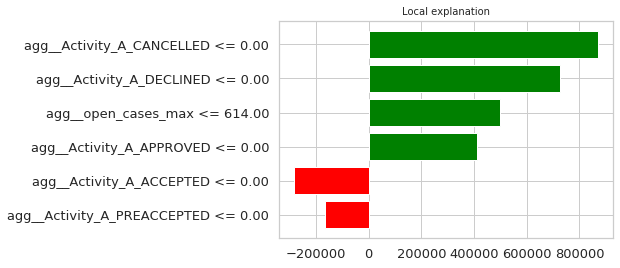

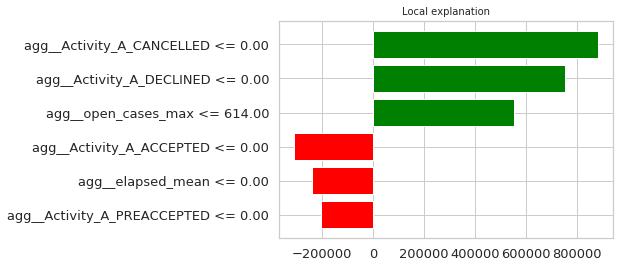

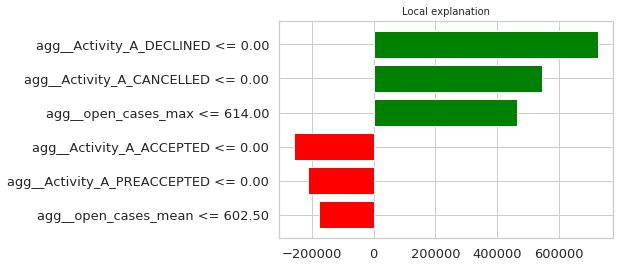

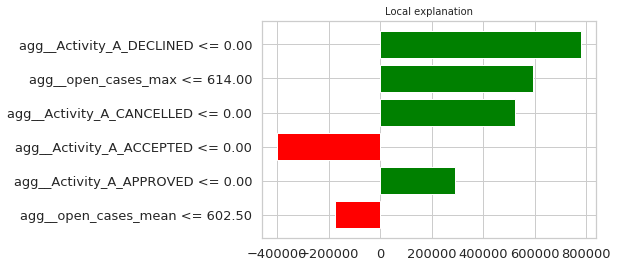

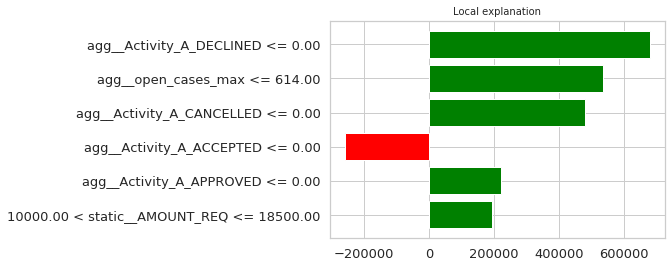

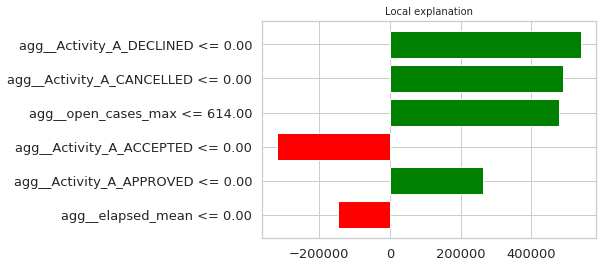

In [33]:
rc={'axes.labelsize': 12, 'xtick.labelsize': 13, 'ytick.labelsize': 13 , 'axes.titlesize': 10}
sns.set(rc)
sns.set_style("whitegrid")
%matplotlib inline
for pre, exp in exp_dict.items():
    print('Explanations for prefix length ', bucket)
    fig = exp.as_pyplot_figure()
    fig.show()
    fig.savefig(MY_WORKSPACE_DIR + "XGBoost/buckets_" + bucket_method + "_" + cls_encoding + "/lime/chunk" + str(part) + "/Local_Expl_" + dataset_ref + "_p" + str(pre) + "_b" + str(bucket) + ".png",bbox_inches='tight',dpi=300)
